# **Modelo de Hull & White**

Se definen los parámetros iniciales con los que vamos a trabajar, en este caso $a$, $T$, $n$, $r_0$, $a$, $\theta$, $\sigma$ y $\Delta$, se realiza un movimiento browniano con una normal estándar para posteriormente con las discretización:

$$r_{k+1} =  r_{k} + (\theta-ar_{k})dt + \sigma\sqrt\Delta Z_{k}$$

simular una trayectoria (en este caso veamos que estamos tomando a $\theta$ como constante) y usando los estimadores máximo verosimiles obtenidos calculamos sus valores:

\begin{align*}
\hat{a} \;&=\; - \frac{\sum_{i=1}^n \big( r_i - r_{i-1} - \theta \Delta \big) r_{i-1}}{\Delta \sum_{i=1}^n r_{i-1}^2} \\[1em]
\hat{\sigma} \;&=\; \sqrt{\frac{1}{n \Delta} \sum_{i=1}^n \left( r_i - r_{i-1} - \big(\theta - \hat{a} r_{i-1}\big)\Delta \right)^2} \\[1em]
\hat{\theta} \;&=\; \frac{1}{n \Delta} \sum_{i=1}^n \big( r_i - r_{i-1} \big) \;+\; \frac{\hat{a}}{n} \sum_{i=1}^n r_{i-1}
\end{align*}


 Finalmente graficamos la simulación.

## **Paso 1**

Se grafica una trayectoria completa del modelo usando el modelo discretizado, en el cual emplearemos $n$ observaciones y con ellas estimaremos los valores de los parámetros $\hat{\alpha}$, $\hat{\sigma^2}$ y $\hat{\theta}$

a estimada = 0.975305064259552  vs a real =  1  diferencia de  0.02469493574044801


sigma estimada = 0.010152301939200798  vs sigma real =  0.01  diferencia de  0.00015230193920079751


theta estimada = 0.07992038931793381  vs theta real =  0.08  diferencia de  7.961068206618904e-05


---------------------------------------------------------------------------------------------------------------


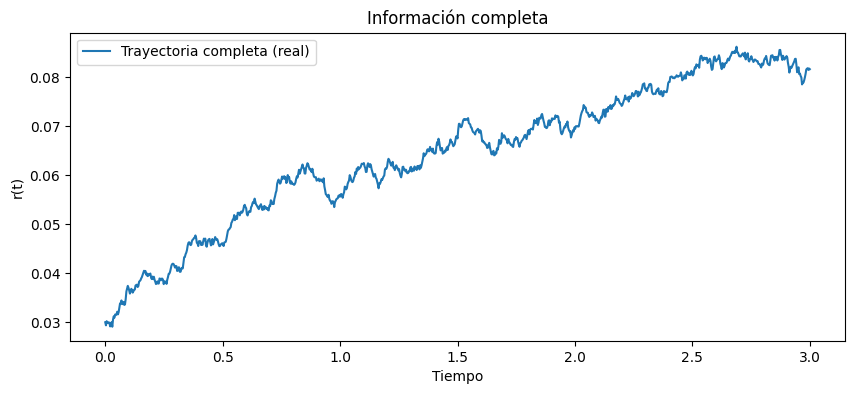

In [18]:
#Importamos las librerias
import numpy as np
import math
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd

#Definimos los parametros
T=3
n=1000
r0=0.03
a=1
theta=0.08
sigma=0.01
semilla =12345
Delta = T/n

#Funcion de la trayectoria con la informacion completa
def simular_euler(T, n, r0, a, theta, sigma, semilla):
    rng = np.random.default_rng(semilla)
    Delta = T/n
    tiempos = np.linspace(0.0, T, n+1)
    r = np.empty(n+1)
    r[0] = r0
    for i in range(n):
        r[i+1] = r[i] + (theta - a*r[i])*Delta + sigma*np.sqrt(Delta)*rng.standard_normal()
    return tiempos, r

#Simulacion de la trayectoria
tiempos, r_completa = simular_euler(T, n, r0, a, theta, sigma, semilla)

#Estimamos los parametros que se obtienen por maxima verosimilitud
def estimadores_HW(r, Delta, theta_const):
    n = len(r) - 1

    #Estimacion de a
    num = np.sum((r[1:] - r[:-1] - theta_const * Delta) * r[:-1])
    den = Delta * np.sum(r[:-1]**2)
    a_hat = - num / den

    # --- Estimador de 'sigma' ---
    resid = r[1:] - r[:-1] - (theta_const - a_hat * r[:-1]) * Delta
    sigma_hat = np.sqrt(np.sum(resid**2) / (n * Delta))

    # --- Estimador de 'theta' ---
    theta_hat = (1 / (n * Delta)) * np.sum(r[1:] - r[:-1]) + (a_hat / n) * np.sum(r[:-1])

    return a_hat, sigma_hat, theta_hat

a_hat, sigma_hat, theta_hat = estimadores_HW(r_completa, Delta, theta)

#Mostramos als diferencias entre los valores reales y los estimados
print("a estimada =", a_hat, " vs a real = ",a, " diferencia de ",abs(a_hat-a))
print('\n')
print("sigma estimada =", sigma_hat," vs sigma real = ", sigma, " diferencia de ",abs(sigma_hat-sigma))
print('\n')
print("theta estimada =", theta_hat, " vs theta real = ", theta, " diferencia de ",abs(theta_hat-theta))
print('\n')
print('---------------------------------------------------------------------------------------------------------------')

#Graficamos parte de la trayectoria
plt.figure(figsize=(10,4))
plt.plot(tiempos, r_completa, label="Trayectoria completa (real)")
plt.xlabel("Tiempo")
plt.ylabel("r(t)")
plt.title("Información completa")
plt.legend()
plt.show()

## **Paso 2**

Posteriormente, quitamos el $(n-k)\%$ de la información, i.e nos quedamos solo con el $k\%$  de la información y procedemos a hacer la estimación de los parámetros y movemos el valor de $k$ hasta que estemos parados en un punto donde la estimación sea muy mala.

a estimada reducida = 0.7070792632533935  vs a real =  1  diferencia de  0.29292073674660646
n
sigma estimada reducida = 0.00543321406808611  vs sigma real =  0.01  diferencia de  0.00456678593191389


theta estimada reducida = 0.06078881235376946  vs theta real =  0.08  diferencia de  0.01921118764623054
---------------------------------------------------------------------------------------------------------------


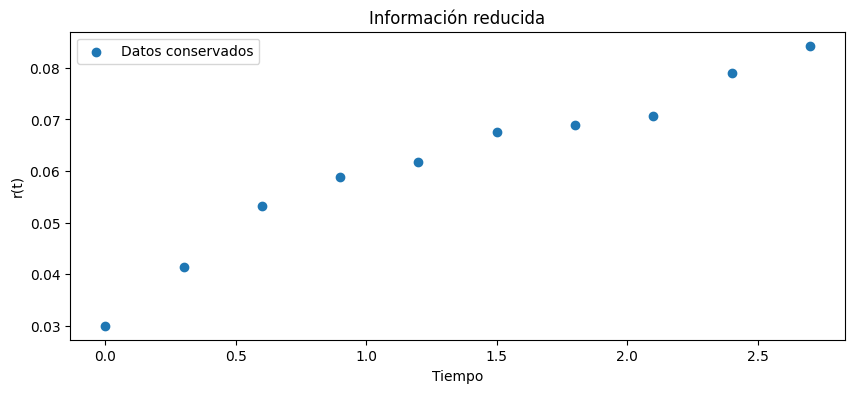

In [19]:
#Seleccionamos cada 10 puntos
cada = 100

def indices_submuestra(n_puntos, cada_cuanto):
    idx = np.arange(n_puntos)
    mascara = (idx % cada_cuanto == 0)
    mascara[-1] = True
    return np.where(mascara)[0]

idx = indices_submuestra(len(tiempos), cada)
tiempos_reduc = tiempos[idx]
r_reduc = r_completa[idx]

#Se define el tamaño de paso entre los tiempos de la selección de sólo el k% de la información
Delta_reducidos = tiempos_reduc[1]-tiempos_reduc[0]

#Reducción de la muestra al k%
def estimadores_reducidos(r_reduc, Delta_reducidos):
    n = len(r_reduc)

    # Construir variables para regresión
    y = r_reduc[1:] - r_reduc[:-1]
    X0 = np.ones_like(r_reduc[:-1])
    X1 = r_reduc[:-1]
    X = np.column_stack([X0, X1])

    # Estimación de beta por mínimos cuadrados
    beta_hat = np.linalg.lstsq(X, y, rcond=None)[0]

    # Transformar beta a parámetros del modelo
    theta_hat_reg = beta_hat[0] / Delta_reducidos
    a_hat_reg = - beta_hat[1] / Delta_reducidos

    # Calcular residuos y sigma
    residuos = y - (theta_hat - a_hat * r_reduc[:-1]) * Delta_reducidos
    sigma_hat_reducida = np.sqrt(np.sum(residuos**2) / (n * Delta_reducidos))

    return a_hat_reg, sigma_hat_reducida, theta_hat_reg


a_hat_reg, sigma_hat_reducida, theta_hat_reg = estimadores_reducidos(r_reduc, Delta_reducidos)

#Imprimimos los valores estimados vs los reales
print("a estimada reducida =", a_hat_reg, " vs a real = ",a, " diferencia de ",abs(a_hat_reg-a))
print('n')
print("sigma estimada reducida =", sigma_hat_reducida," vs sigma real = ", sigma, " diferencia de ",abs(sigma_hat_reducida-sigma))
print('\n')
print("theta estimada reducida =", theta_hat_reg, " vs theta real = ", theta, " diferencia de ",abs(theta_hat_reg-theta))
print('---------------------------------------------------------------------------------------------------------------')

#Graficamos los puntos que se seleccionaron para la reducción de dimension
plt.figure(figsize=(10,4))
L=n
plt.scatter(tiempos_reduc[tiempos_reduc<=tiempos[L-1]],r_reduc[tiempos_reduc<=tiempos[L-1]], label="Datos conservados")
plt.xlabel("Tiempo")
plt.ylabel("r(t)")
plt.title("Información reducida")
plt.legend()
plt.show()

## **Paso 3**

Finalmente usando de puentes brownianos reconstruimos el $(n-k)\%$ de la información faltante, posteriormente realizamos la estimación de los parámetros y comparamos con los obtenidos en los pasos anteriores.

a estimada reducida = 1.079492012893838  vs a real =  1  diferencia de  0.0794920128938379


sigma estimada reducida = 0.05879009321924115  vs sigma real =  0.01  diferencia de  0.048790093219241146


theta estimada reducida = 0.0865050967783732  vs theta real =  0.08  diferencia de  0.006505096778373201
---------------------------------------------------------------------------------------------------------------


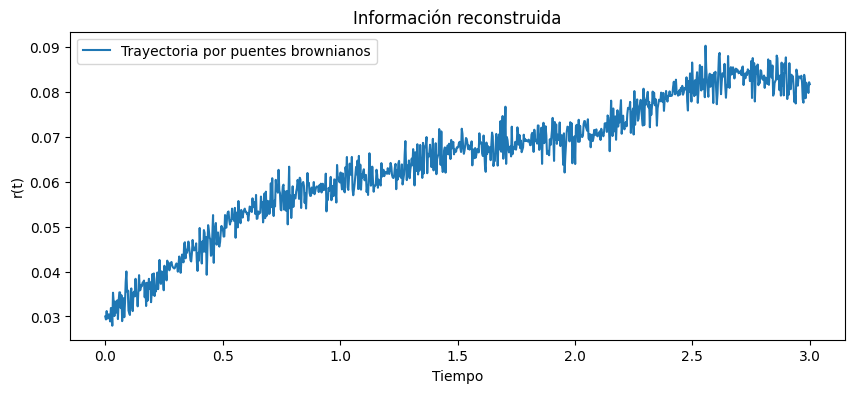

In [20]:
#Construccion de la informacion faltante por medio de puentes brownianos
def reconstruir_puentes(tiempos_red, r_red, a_red, theta_red, sigma_red, cada, semilla):
    rng = np.random.default_rng(semilla)
    r_rec = [r_red[0]]  # primer punto
    tiempos_rec = [tiempos_red[0]]

    for i in range(len(r_red)-1):
        r0 = r_red[i]
        r1 = r_red[i+1]
        m = cada - 1
        Delta_step = (tiempos_red[i+1] - tiempos_red[i]) / (m+1)

        for k in range(1, m+1):
            media = r0 + (k/(m+1))*(r1 - r0)
            varianza = sigma**2 * Delta_step * k*(m+1-k)/(m+1)
            r_k = media + np.sqrt(varianza) * rng.standard_normal()
            r_rec.append(r_k)
            tiempos_rec.append(tiempos_red[i] + k*Delta_step)
        # agregamos el punto final del intervalo
        r_rec.append(r1)
        tiempos_rec.append(tiempos_red[i+1])
        tiempos_pb = np.array(tiempos_rec)
        r_pb = np.array(r_rec)
    return tiempos_pb, r_pb

# Reconstruimos la trayectoria completa
tiempos_rec, r_rec = reconstruir_puentes(tiempos_reduc, r_reduc, a_hat_reg, theta_hat_reg, sigma_hat_reducida, cada, semilla)

# Estimamos de nuevo los parámetros con la trayectoria reconstruida
a_hat_pb,sigma_hat_pb, theta_hat_pb = estimadores_HW(r_rec, Delta, theta_hat_reg)

#Mostramos los valores estimados de la reconstrucción contra los valores reales
print("a estimada reducida =", a_hat_pb, " vs a real = ",a, " diferencia de ",abs(a_hat_pb-a))
print('\n')
print("sigma estimada reducida =", sigma_hat_pb," vs sigma real = ", sigma, " diferencia de ",abs(sigma_hat_pb-sigma))
print('\n')
print("theta estimada reducida =", theta_hat_pb, " vs theta real = ", theta, " diferencia de ",abs(theta_hat_pb-theta))
print('---------------------------------------------------------------------------------------------------------------')

#Graficamos la reconstrucción de la información
plt.figure(figsize=(10,4))
plt.plot(tiempos_rec, r_rec, label="Trayectoria por puentes brownianos")
plt.xlabel("Tiempo")
plt.ylabel("r(t)")
plt.title("Información reconstruida")
plt.legend()
plt.show()

## **Paso 4**
Graficamos la trayectoria con información completa, lo extración de sólo el $k\%$ de la información y la información reconstruida por medio de puentes brownianos. Y finalmente mostramos una comparación entre los valores obtenidos por los diferentes métodos.

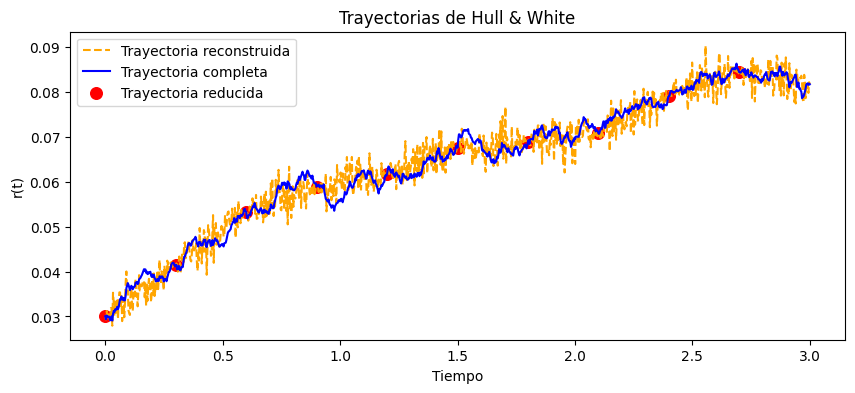

In [21]:
#Graficamos el paso 1, paso 2 y paso 3 juntos
plt.figure(figsize=(10,4))
plt.plot(tiempos_rec, r_rec,linestyle="--",color="orange", label="Trayectoria reconstruida")
plt.plot(tiempos, r_completa,color="blue", label="Trayectoria completa")
plt.scatter(tiempos_reduc[tiempos_reduc<=tiempos[L-1]],r_reduc[tiempos_reduc<=tiempos[L-1]],s=70, color ="red", label="Trayectoria reducida")
plt.xlabel("Tiempo")
plt.ylabel("r(t)")
plt.title("Trayectorias de Hull & White")
plt.legend()
plt.show()

In [22]:
#Tabla con comparación de parámetros reales vs estimados
df_resultados = pd.DataFrame({
    "Parámetro": ["a", "sigma", "theta"],
    "Real": [a, sigma, theta],
    "Completo": [a_hat, sigma_hat, theta_hat],
    "Reducida (1%)": [a_hat_reg, sigma_hat_reducida, theta_hat_reg],
    "Reconstruida": [a_hat_pb, sigma_hat_pb, theta_hat_pb]
})

df_resultados = df_resultados.set_index("Parámetro")
df_resultados

,Real,Completo,Reducida (1%),Reconstruida
Parámetro,,,,
a,1.00,0.975305,0.707079,1.079492
sigma,0.01,0.010152,0.005433,0.058790
theta,0.08,0.079920,0.060789,0.086505


Finalmente, se corren las simulaciones $m=100$ veces de tal forma de tener una muestra más amplia de los estimadores, para posteriormente con el cálculo de los parámetros las $m$ veces se calcule el promedio y se obtengan valores más concretos respecto al valor de los estimadores.

In [23]:
#Comparación de los parámetros obtenidos en m simulaciones vs los reales
resultados = []
Nsim = 100

for i in range(Nsim):
    tiempos, r = simular_euler(T, n, r0, a, theta, sigma, semilla=i)  # semilla cambia cada vez
    a_hat, sigma_hat, theta_hat = estimadores_HW(r_completa, Delta, theta)
    a_hat_reg, sigma_hat_reducida, theta_hat_reg = estimadores_reducidos(r_reduc, Delta_reducidos)
    tiempos_rec, r_rec = reconstruir_puentes(tiempos_reduc, r_reduc, a_hat_reg, theta_hat_reg, sigma_hat_reducida, cada, semilla)
    a_hat_pb,sigma_hat_pb, theta_hat_pb = estimadores_HW(r_rec, Delta, theta_hat_reg)

    resultados.append({
        "a_completo": a_hat,
        "sigma_completo": sigma_hat,
        "theta_completo": theta_hat,
        "a_reducido": a_hat_reg,
        "sigma_reducido": sigma_hat_reducida,
        "theta_reducido": theta_hat_reg,
        "a_reconstruido": a_hat_pb,
        "sigma_reconstruido": sigma_hat_pb,
        "theta_reconstruido": theta_hat_pb
    })


#Dataframe con los estimadores
df_resultados = pd.DataFrame(resultados)

# Calculamos los promedios de cada estimador
a_hat_mean = df_resultados["a_completo"].mean()
sigma_hat_mean = df_resultados["sigma_completo"].mean()
theta_hat_mean = df_resultados["theta_completo"].mean()

a_hat_reg_mean = df_resultados["a_reducido"].mean()
sigma_hat_reducida_mean = df_resultados["sigma_reducido"].mean()
theta_hat_reg_mean = df_resultados["theta_reducido"].mean()

a_hat_pb_mean = df_resultados["a_reconstruido"].mean()
sigma_hat_pb_mean = df_resultados["sigma_reconstruido"].mean()
theta_hat_pb_mean = df_resultados["theta_reconstruido"].mean()

# Creamos la tabla
df_tabla_final = pd.DataFrame({
    "Parámetro": ["a", "sigma", "theta"],
    "Real": [a, sigma, theta],
    "Completo": [a_hat_mean, sigma_hat_mean, theta_hat_mean],
    "Reducida (1%)": [a_hat_reg_mean, sigma_hat_reducida_mean, theta_hat_reg_mean],
    "Reconstruida": [a_hat_pb_mean, sigma_hat_pb_mean, theta_hat_pb_mean]
})

df_tabla_final = df_tabla_final.set_index("Parámetro")
df_tabla_final

,Real,Completo,Reducida (1%),Reconstruida
Parámetro,,,,
a,1.00,0.975305,0.707079,1.079492
sigma,0.01,0.010152,0.005433,0.058790
theta,0.08,0.079920,0.060789,0.086505
